## Download Data

The radiology dataset is described in the paper
["Radiology Objects in COntext (ROCO): A Multimodal Image Dataset"](https://labels.tue-image.nl/wp-content/uploads/2018/09/AM-04.pdf)


However, it consists of 50,000 images and the canonical link downloads the images one at a time.

The dataset is also available on Kaggle, so use that instead.

## Step 1: Download data

Download data from https://www.kaggle.com/datasets/virajbagal/roco-dataset?resource=download
and upload to this folder as archive.zip

You could also set up Kaggle authentication as described in https://www.kaggle.com/docs/api#authentication
and run:
<pre>
curl -L -o archive.zip  https://www.kaggle.com/api/v1/datasets/download/virajbagal/roco-dataset
</pre>

## Step 2: Prepare data

In [ ]:
!unzip -q archive.zip

In [2]:
!head all_data/train/radiology/traindata.csv

id,name,caption
ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg," Computed tomography scan in axial view showing obliteration of the left maxillary sinus
"
ROCO_00003,PMC2837471_IJD2009-150251.001.jpg," Bacterial contamination occurred after completion of root canal treatment in the tooth, which remained with a temporary filling for 15 month.
"
ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg," The patient had residual paralysis of the hand after poliomyelitis. It was necessary to stabilize the thumb with reference to the index finger. This was accomplished by placing a graft from the bone bank between the first and second metacarpals. The roentgenogram shows the complete healing of the graft one year later.
"
ROCO_00005,PMC3745845_IJD2013-683423.005.jpg," Panoramic radiograph after immediate loading.
"
ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg," Plain abdomen x-ray: Multiple air levels at the mid-abdomen (arrows), no radiopaque shadow, and no air under the diaphragm.


In [3]:
!ls -l all_data/train/radiology/images/PMC4083729_AMHSR-4-14-g002.jpg

-rw-r--r-- 1 jupyter jupyter 67352 Aug 23  2020 all_data/train/radiology/images/PMC4083729_AMHSR-4-14-g002.jpg


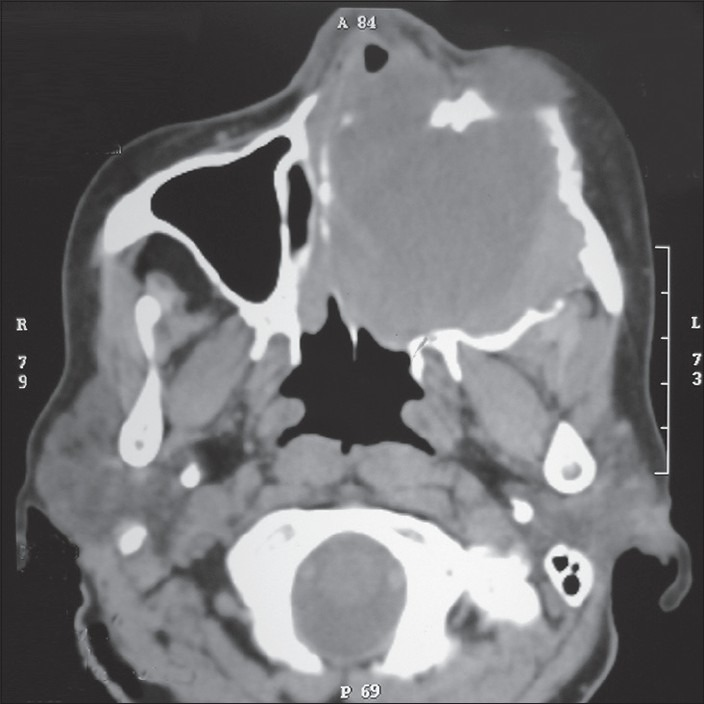

In [5]:
from IPython.display import Image as showImage
showImage(filename='all_data/train/radiology/images/PMC4083729_AMHSR-4-14-g002.jpg') 

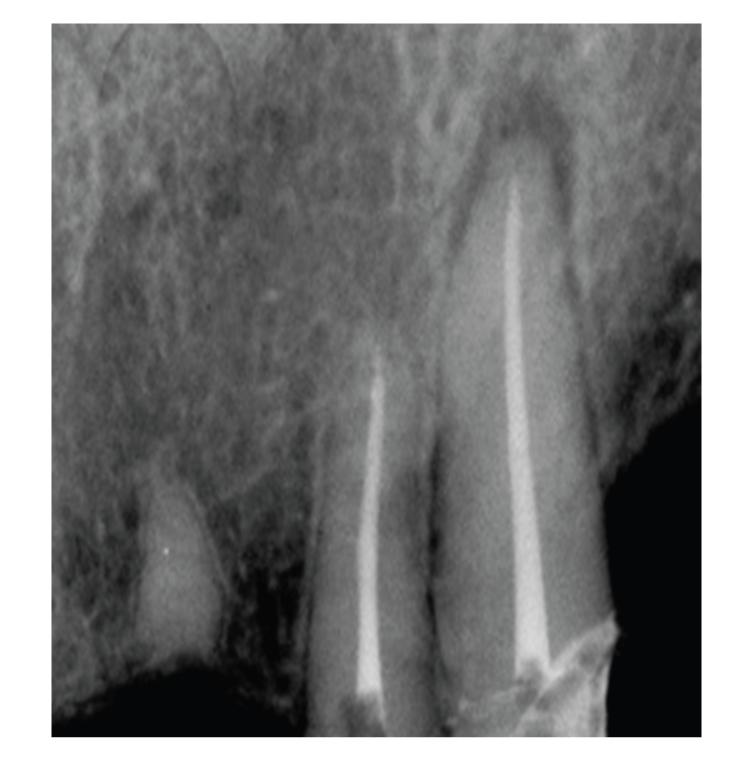

In [7]:
showImage(filename='all_data/train/radiology/images/PMC2837471_IJD2009-150251.001.jpg')

## Step 3: Create message corresponding to a single image

See: https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora for the format of the message to fine-tune gemma with

In [11]:
def format_message(filename, caption, image_dir="all_data/train/radiology/images"):
    system_message = "You are an expert researcher in radiology."
    user_prompt = "Write a caption for this image explaining what it depicts, suitable for use in a research publication."
    return {
        "messages": [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": user_prompt,
                    },
                    {
                        "type": "image",
                        "image": f"{image_dir}/{filename}", # the input image
                    },
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": caption.strip()}], # desired output
            },
        ],
    }

In [9]:
import pandas as pd
traindata = pd.read_csv("all_data/train/radiology/traindata.csv")
traindata[:3]

,id,name,caption
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...


In [12]:
format_message(traindata['name'][1], traindata['caption'][1])

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are an expert researcher in radiology.'}]},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write a caption for this image explaining what it depicts, suitable for use in a research publication.'},
    {'type': 'image',
     'image': 'all_data/train/radiology/images/PMC2837471_IJD2009-150251.001.jpg'}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Bacterial contamination occurred after completion of root canal treatment in the tooth, which remained with a temporary filling for 15 month.'}]}]}

In [17]:
traindata[:3].apply(lambda row: format_message(row['name'], row['caption']),  axis=1)

0    {'messages': [{'role': 'system', 'content': [{...
1    {'messages': [{'role': 'system', 'content': [{...
2    {'messages': [{'role': 'system', 'content': [{...
dtype: object

## Step 4: Write jsonl

In [19]:
import json
messages = list(traindata[:3].apply(lambda row: format_message(row['name'], row['caption']),  axis=1))
messages

[{'messages': [{'role': 'system',
    'content': [{'type': 'text',
      'text': 'You are an expert researcher in radiology.'}]},
   {'role': 'user',
    'content': [{'type': 'text',
      'text': 'Write a caption for this image explaining what it depicts, suitable for use in a research publication.'},
     {'type': 'image',
      'image': 'all_data/train/radiology/images/PMC4083729_AMHSR-4-14-g002.jpg'}]},
   {'role': 'assistant',
    'content': [{'type': 'text',
      'text': 'Computed tomography scan in axial view showing obliteration of the left maxillary sinus'}]}]},
 {'messages': [{'role': 'system',
    'content': [{'type': 'text',
      'text': 'You are an expert researcher in radiology.'}]},
   {'role': 'user',
    'content': [{'type': 'text',
      'text': 'Write a caption for this image explaining what it depicts, suitable for use in a research publication.'},
     {'type': 'image',
      'image': 'all_data/train/radiology/images/PMC2837471_IJD2009-150251.001.jpg'}]},
   {'ro

In [21]:
def write_messages(messages, filename):
    with open(filename, "w") as ofp:
        for message in messages:
            ofp.write(json.dumps(message) + "\n")
    return filename

write_messages(messages, "messages.jsonl")

'messages.jsonl'

In [22]:
!head messages.jsonl

{"messages": [{"role": "system", "content": [{"type": "text", "text": "You are an expert researcher in radiology."}]}, {"role": "user", "content": [{"type": "text", "text": "Write a caption for this image explaining what it depicts, suitable for use in a research publication."}, {"type": "image", "image": "all_data/train/radiology/images/PMC4083729_AMHSR-4-14-g002.jpg"}]}, {"role": "assistant", "content": [{"type": "text", "text": "Computed tomography scan in axial view showing obliteration of the left maxillary sinus"}]}]}
{"messages": [{"role": "system", "content": [{"type": "text", "text": "You are an expert researcher in radiology."}]}, {"role": "user", "content": [{"type": "text", "text": "Write a caption for this image explaining what it depicts, suitable for use in a research publication."}, {"type": "image", "image": "all_data/train/radiology/images/PMC2837471_IJD2009-150251.001.jpg"}]}, {"role": "assistant", "content": [{"type": "text", "text": "Bacterial contamination occurre

In [23]:
## Write it fully
messages = list(traindata.apply(lambda row: format_message(row['name'], row['caption']),  axis=1))
write_messages(messages, "messages.jsonl")
!wc messages.jsonl

   65450  4394900 38239457 messages.jsonl
